### Rotate velocities with respect to SSH contours and FSLE eigenvectors

In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cmocean
import datetime
import math
import gsw
import stat
import scipy
import pyproj
from scipy.signal import savgol_filter

%matplotlib inline

plt.rcParams['font.size'] = '14'

In [ ]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

In [2]:
import imp
import src.importData as imports

import src.calc as calc
import src.plots as plots
import src.velocities as vel
import src.concat as ct
import src.interpolation as interp
import src.settings as settings
import src.stats as stats

floatids = [8489, 8492, 8493]
ema = imports.importFloatData(floatids)

datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [3]:
# half-inertial pair averaged dataset
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
floatids = [8489, 8492, 8493]
ds = imports.sub_inertial_ds(ema, floatids, datadir, xdim = 'distance')

In [97]:
u_abs = {}
v_abs = {}
CT, SA = {}, {}

for floatid in floatids:
    u_abs[floatid], v_abs[floatid] = ds[floatid].u, ds[floatid].v
    CT[floatid], SA[floatid] = ds[floatid].CT, ds[floatid].SA

In [98]:
floatid = 8493
float_num = ema[floatid]
rs = calc.findRSperiod(float_num)

In [99]:
adt = alt_cmems.adt.sel(latitude = slice(-56, -51), longitude = slice(148, 158))

(-55.5, -53.5)

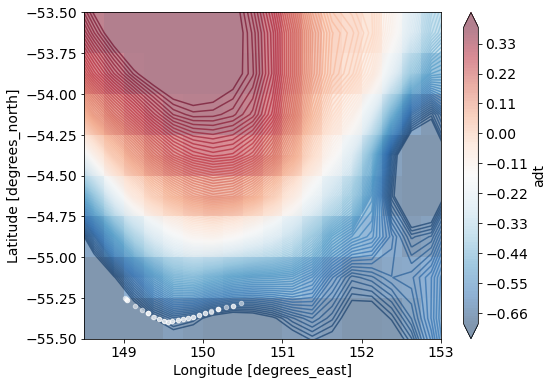

In [100]:
ssh_contours = np.arange(-0.7, 0.4, 0.01)

prof1, prof2 = 0, 40

fig, ax = plt.subplots(figsize = (8,6))
adt.interp(time = float_num.time[rs])[prof1:prof2].mean(dim = 'time').plot(levels = ssh_contours, alpha = 0.5)
CS = adt.interp(time = float_num.time[rs])[prof1:prof2].mean(dim = 'time').plot.contour(levels = ssh_contours, alpha = 0.6)
plt.scatter(float_num.longitude[prof1:prof2], float_num.latitude[prof1:prof2], s = 20, zorder = 3, c = 'w', alpha = 0.5)
plt.xlim(148.5, 153)
plt.ylim(-55.5, -53.5)

In [101]:
def get_streamline_paths(paths):

    x_values = paths[0].vertices[:,0]
    y_values = paths[0].vertices[:,1]
    
    for ind in range(1, len(paths)):

        x = paths[ind].vertices[:,0]
        y = paths[ind].vertices[:,1]

        x_values = np.concatenate((x_values, x))
        y_values = np.concatenate((y_values, y))
        
    return(x_values, y_values)
    

In [108]:
adt_interp = interp.interpToFloat(float_num, adt)[rs].interpolate_na(dim = 'profile', method= 'nearest')
ssh_contours = np.arange(-0.9, 0.4, 0.01)

In [110]:
adt_interp = stats.temporalError(float_num, adt, method = 'interp')[0][rs]

In [112]:
float(adt_interp[0])

-0.7227848876537533

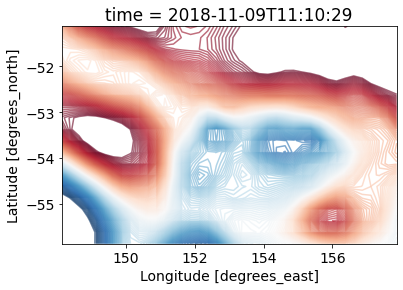

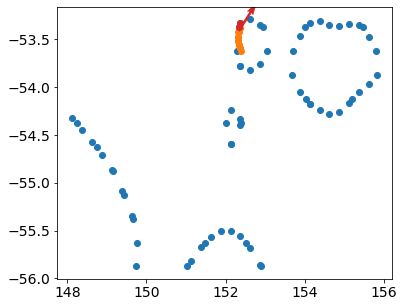

In [103]:
i = 112

geodesic = pyproj.Geod(ellps='WGS84')

float_times = interp.interp_nats(float_num.time[rs], float_num.time[rs])
lats = savgol_filter(float_num.latitude, 9, 3, axis=-1, mode='interp')
lons = savgol_filter(float_num.longitude, 9, 3, axis=-1, mode='interp')

adt_interp_t = adt.interp(time = float_times)
CS = adt_interp_t[i].plot.contour(levels = ssh_contours, alpha = 0.6)
contour_ind, contour_val = stats.find_nearest(ssh_contours, [float(adt_interp[i])])

paths = CS.collections[contour_ind].get_paths()
x, y = get_streamline_paths(paths)
      
# x = savgol_filter(x, 9, 3, axis=-1, mode='interp')
# y = savgol_filter(y, 9, 3, axis=-1, mode='interp')

#calcualte the xoordinate with the shortest distance from float position
dist = []
for k in range(0, len(x)):
    distance = geodesic.inv(x[k], y[k], lons[i], lats[i])[2]
    dist.append(distance)

ind = int(np.where(dist == np.nanmin(dist))[0])

x2, y2 = x[ind+1], y[ind+1]

# use the contour index to find the previous x and y coordinate of the contour
x1, y1 = x[ind], y[ind]

# calcaulte the bearing from one contour coordinate to the next 
fwd_azimuth, back_azimuth, distance = geodesic.inv(x1, y1, x2, y2)

fwd_azimuth += 360
fwd_azimuth = fwd_azimuth % 360

angle_rad = np.deg2rad(fwd_azimuth)
y_vector = 0.3 * np.cos(angle_rad) 
x_vector = 0.3 * np.sin(angle_rad) 


fig, ax = plt.subplots(figsize = (6,5))
plt.scatter(x,y)
plt.scatter(lons[i-10:i+3], float_num.latitude[i-10:i+3], c = 'tab:orange')
plt.scatter(x1, y1, c = 'tab:red')
plt.scatter(x2, y2, c = 'tab:red')
ax.quiver(lons[i], lats[i], x_vector, y_vector, color = 'tab:red', scale = 3)

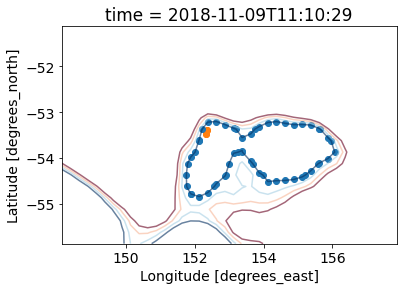

In [104]:
cs = adt_interp_t[i].plot.contour(levels = np.arange(-0.5, -0.3, 0.05), alpha = 0.6)
contour_ind, contour_val = stats.find_nearest(np.arange(-0.5, -0.3, 0.05), [float(adt_interp[i])])
p2 = cs.collections[contour_ind].get_paths()[2].vertices
xs, ys = p2[:,0], p2[:,1] 

plt.scatter(lons[i-3:i+3], float_num.latitude[i-3:i+3], c = 'tab:orange')
plt.scatter(xs, ys, c = 'tab:blue')

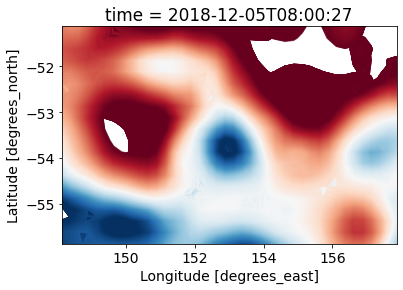

In [105]:
bearing = []

geodesic = pyproj.Geod(ellps='WGS84')

float_times = interp.interp_nats(float_num.time[rs], float_num.time[rs])
adt_interp_t = adt.interp(time = float_times)

lats = savgol_filter(float_num.latitude, 9, 3, axis=-1, mode='interp')
lons = savgol_filter(float_num.longitude, 9, 3, axis=-1, mode='interp')

for i in range(0, len(adt_interp)):
    
    CS = adt_interp_t[i].plot.contour(levels = ssh_contours, alpha = 0.6)
    
    # find nearest SSH contour to float profile location 
    contour_ind, contour_val = stats.find_nearest(ssh_contours, [float(adt_interp[i])])

    # extract all x an y positions for that contour
    paths = CS.collections[contour_ind].get_paths()
    x, y = get_streamline_paths(paths)

#     x = savgol_filter(x, 9, 3, axis=-1, mode='interp')
#     y = savgol_filter(y, 9, 3, axis=-1, mode='interp')

    #calcualte the xoordinate with the shortest distance from float position
    dist = []
    for k in range(0, len(x)):
        distance = geodesic.inv(x[k], y[k], lons[i], lats[i])[2]
        dist.append(distance)

    ind = np.where(dist == np.nanmin(dist))[0]

    if len(ind) > 1:
        ind = int(ind[0])
    elif len(ind) == 0:
        ind = np.nan
    else:
        ind = int(ind)

    if ~np.isnan(ind):
        try:
            # x and y position of SSH streamline nearest to float
            x1, y1 = x[ind], y[ind]
            # x and y position of SSH streamline ahead of float
            x2, y2 = x[ind+1], y[ind+1]
        except:
            # x and y position of SSH streamline behind float
            x1, y1 = x[ind-1], y[ind-1]
            # x and y position of SSH streamline nearest to float
            x2, y2 = x[ind], y[ind]

        # calcaulte the bearing from one contour coordinate to the next 
        fwd_azimuth, back_azimuth, distance = geodesic.inv(x1, y1, x2, y2)

        fwd_azimuth += 360
        fwd_azimuth = fwd_azimuth % 360
        if fwd_azimuth == 0:
            bearing.append(np.nan)
        else:
            bearing.append(fwd_azimuth)
        
    else:
        bearing.append(np.nan)
            
        
ssh_brngs = np.asarray(bearing)

In [54]:
speed = calc.speed(ds[floatid].u, ds[floatid].v)

(-54.5, -52.0)

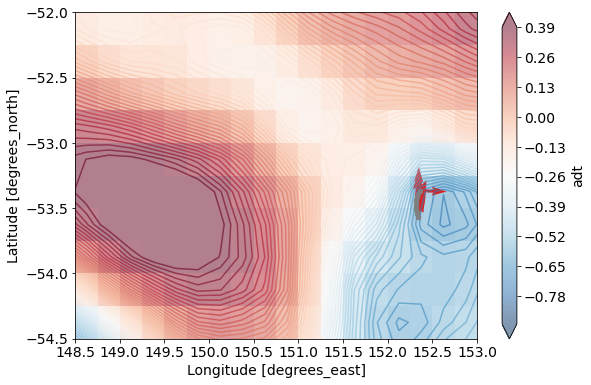

In [119]:
angle_rad = np.deg2rad(ssh_brngs)
y_vector = speed.mean(dim = 'pressure') * np.cos(angle_rad) 
x_vector = speed.mean(dim = 'pressure') * np.sin(angle_rad) 


prof1, prof2 = 105,115


fig, ax = plt.subplots(figsize = (9,6))
adt_interp_t[prof1:prof2].mean(dim = 'time').plot(levels = ssh_contours, alpha = 0.5)
adt_interp_t[prof1:prof2].mean(dim = 'time').plot.contour(levels = np.arange(-0.8, 0.4, 0.02), alpha = 0.6)
plt.scatter(lons[prof1:prof2], lats[prof1:prof2], s = 20, zorder = 3, c = 'grey')
ax.quiver(lons[prof1:prof2], lats[prof1:prof2], x_vector[prof1:prof2], y_vector[prof1:prof2], color = 'tab:red', scale = 3)
plt.xlim(148.5, 153)
plt.ylim(-54.5, -52)

Text(0.5, 1.0, 'SSH streamline direciton')

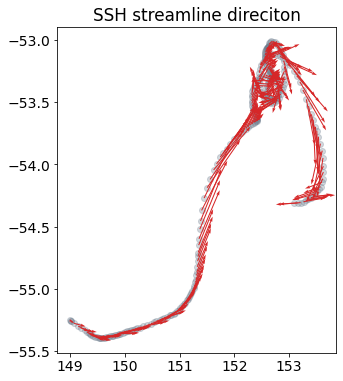

In [120]:
fig, ax = plt.subplots(figsize = (5,6))
ax.scatter(lons[rs], lats[rs], c= 'slategrey', alpha = 0.3)
ax.quiver(lons[rs], lats[rs], x_vector, y_vector, color = 'tab:red', scale = 3)
plt.title('SSH streamline direciton')

### Meridional and zonal components

Text(0.5, 1.0, 'EM-8493')

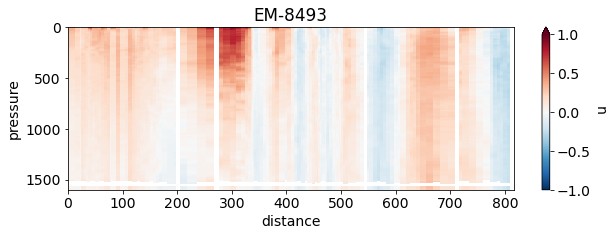

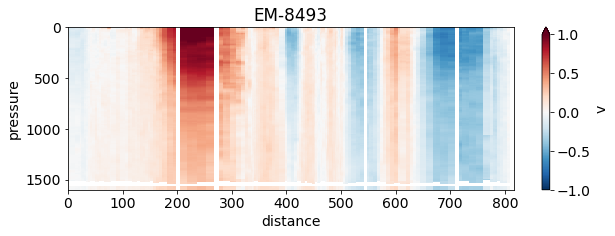

In [65]:
fig, ax = plt.subplots(figsize = (10,3))
ds[floatid].u.plot(x = 'distance',  vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax.invert_yaxis()
plt.title(f'EM-{floatid}')

fig, ax = plt.subplots(figsize = (10,3))
ds[floatid].v.plot(x = 'distance',  vmin = -1, vmax = 1, cmap = 'RdBu_r')
ax.invert_yaxis()
plt.title(f'EM-{floatid}')

### Rotated with respect to SSH streamlines

In [58]:
# u_rot, v_rot, theta = vel.rotate_velocities(float_num, floatid, ds[floatid].u, ds[floatid].v, 
#                                             smooth_vels = False, along_stream = ssh_brngs)

18 -0.7199999999999999
18 -0.7199999999999999
18 -0.7199999999999999
18 -0.7199999999999999
18 -0.7199999999999999
19 -0.7099999999999999
19 -0.7099999999999999
19 -0.7099999999999999
19 -0.7099999999999999
19 -0.7099999999999999
19 -0.7099999999999999
19 -0.7099999999999999
19 -0.7099999999999999
19 -0.7099999999999999
19 -0.7099999999999999
20 -0.6999999999999998
20 -0.6999999999999998
22 -0.6799999999999998
22 -0.6799999999999998
22 -0.6799999999999998
22 -0.6799999999999998
23 -0.6699999999999998
23 -0.6699999999999998
25 -0.6499999999999998
25 -0.6499999999999998
26 -0.6399999999999998
26 -0.6399999999999998
28 -0.6199999999999998
28 -0.6199999999999998
28 -0.6199999999999998
28 -0.6199999999999998
29 -0.6099999999999998
29 -0.6099999999999998
31 -0.5899999999999997
31 -0.5899999999999997
32 -0.5799999999999997
32 -0.5799999999999997
34 -0.5599999999999997
34 -0.5599999999999997
36 -0.5399999999999997
37 -0.5299999999999997
38 -0.5199999999999997
39 -0.5099999999999997
40 -0.49999

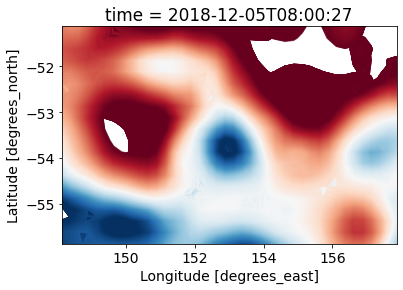

In [115]:
lats = savgol_filter(ds[floatid].latitude, 9, 3, axis=-1, mode='interp')
lons = savgol_filter(ds[floatid].longitude, 9, 3, axis=-1, mode='interp')
obs_times = ds[floatid].time

imp.reload(vel)
ssh_brngs, u_rot, v_rot = vel.rotate_to_ssh(adt, ds[floatid], lons, lats, obs_times, smooth_contours = True, window = 9)

Text(0.5, 1.0, 'EM-8493')

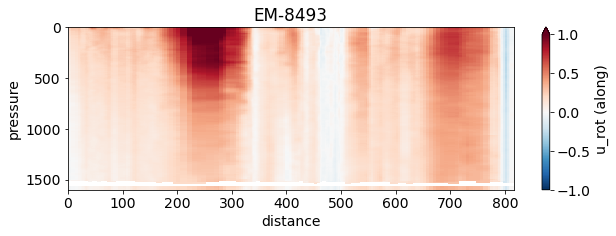

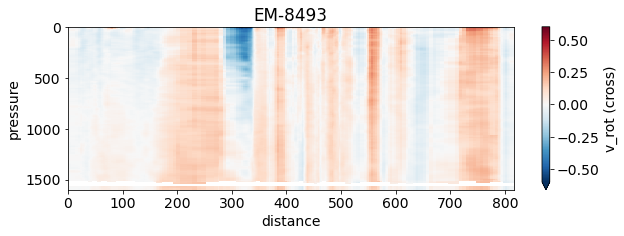

In [117]:
fig, ax = plt.subplots(figsize = (10,3))
u_rot.rolling(distance = 5, min_periods = 3).mean().plot(x = 'distance', vmin = -1, vmax = 1, 
                                                                 cmap = 'RdBu_r',
                                                                 cbar_kwargs = dict(label = 'u_rot (along)'))
ax.invert_yaxis()
plt.title(f'EM-{floatid}')

fig, ax = plt.subplots(figsize = (10,3))
v_rot.rolling(distance = 5, min_periods = 3).mean().plot(x = 'distance', vmin = -0.6, vmax = 0.6, 
                                                     cmap = 'RdBu_r',cbar_kwargs = dict(label = 'v_rot (cross)'))
                                                            
ax.invert_yaxis()
plt.title(f'EM-{floatid}')

### Shipboard ADCP velocities along the Triaxus transect

In [30]:
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'GEM')
satgem = imports.importNetCDF(datadir, 'satGEM_Macq.nc')

In [31]:
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'triaxus')
folder = 'in2018_v05CtdAvgTriaxus_VerticalCasts_nc'
file = 'in2018_v05_04_002AvgCast.nc'
triaxus_vertical_cast = imports.importNetCDF(datadir, file, datatype = folder)

In [32]:
#ADCP
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'adcp')
folder = 'in2018_v05_ADCP_nc'
file = 'in2018_v05_os150nb.nc'
adcp = imports.importNetCDF(datadir, file, datatype = folder)

In [33]:
start = triaxus_vertical_cast.time.values[0] #- np.timedelta64(1, 'D')
end = triaxus_vertical_cast.time.values[-1] #+ np.timedelta64(1, 'D')

In [34]:
adcp_sel = adcp.sel(time = slice(start - np.timedelta64(10, 'm'), end - np.timedelta64(10, 'm')))
adcp_sel = adcp_sel.rename({'lat':'latitude', 'lon':'longitude'})

In [35]:
depth = adcp_sel.depth[0]
v = adcp_sel.v.assign_coords(depth_cell=depth.data)
u = adcp_sel.u.assign_coords(depth_cell=depth.data)

In [36]:
lons, lats = adcp_sel.longitude, adcp_sel.latitude

### rotate velocities with respect to GEM dynamic height streamlines

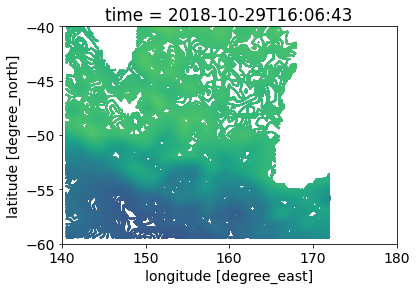

In [45]:
imp.reload(vel)
gem_dyn_m_brngs, u_rot, v_rot = vel.rotate_to_ssh(satgem.dynamic_height, adcp_sel, lons, lats, adcp_sel.time)

In [52]:
dyn_m_interp = stats.temporalError(adcp_sel, satgem.dynamic_height, method = 'interp')[0]
dyn_m_contours = np.arange(np.floor(np.nanmin(dyn_m_interp)), np.ceil(np.nanmax(dyn_m_interp)), 0.01)

(-55.0, -53.5)

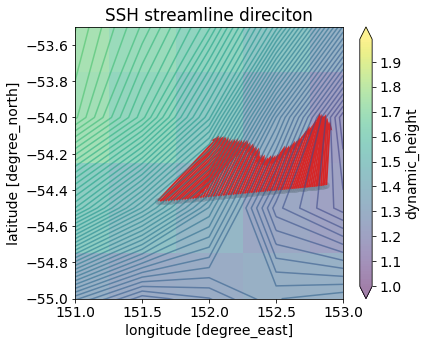

In [53]:
angle_rad = np.deg2rad(gem_dyn_m_brngs)
speed = calc.speed(u, v)
y_vector = speed.mean(dim = 'depth_cell') * np.cos(angle_rad) 
x_vector = speed.mean(dim = 'depth_cell') * np.sin(angle_rad) 

times_no_nat = interp.interp_nats(adcp_sel.time, adcp_sel.time)
dyn_m_interp_t = satgem.dynamic_height.interp(time = times_no_nat)

fig, ax = plt.subplots(figsize = (6,5))
dyn_m_interp_t.mean(dim = 'time').plot(levels = dyn_m_contours, alpha = 0.5)
dyn_m_interp_t.mean(dim = 'time').plot.contour(levels = dyn_m_contours, alpha = 0.6)

ax.scatter(lons, lats, c= 'slategrey', alpha = 0.3)
ax.quiver(lons, lats, x_vector, y_vector, color = 'tab:red', scale = 3)
plt.title('SSH streamline direciton')
plt.xlim(151,153)
plt.ylim(-55,-53.5)

In [54]:
u_rot = u_rot.assign_coords(depth_cell=depth.data)
v_rot = v_rot.assign_coords(depth_cell=depth.data)

Text(0, 0.5, 'depth (m)')

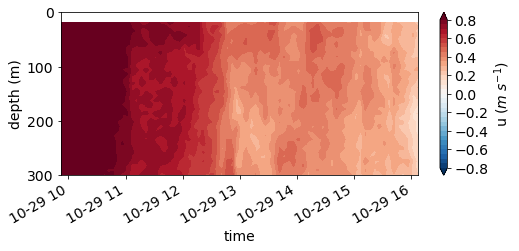

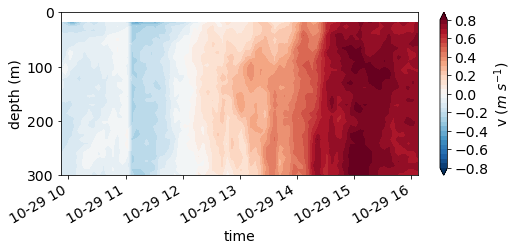

In [55]:
fig, ax = plt.subplots(figsize = (8,3))
u_rot.plot.contourf(x = 'time', cmap = 'RdBu_r', levels = np.arange(-0.8, 0.85, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'u ($m$ $s^{-1}$)'))
ax.set_ylim(0,300)
ax.invert_yaxis()
plt.xlabel('time')
plt.ylabel('depth (m)')

fig, ax = plt.subplots(figsize = (8,3))
v_rot.plot.contourf(x = 'time', cmap = 'RdBu_r', levels = np.arange(-0.8, 0.85, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'v ($m$ $s^{-1}$)'))
ax.set_ylim(0,300)
ax.invert_yaxis()
plt.xlabel('time')
plt.ylabel('depth (m)')

### rotate velocities with respect to ADT streamlines 

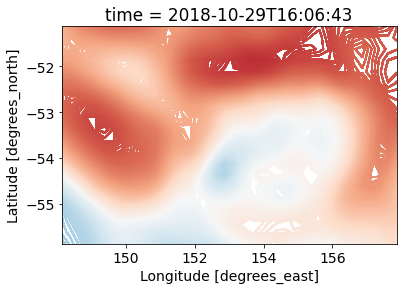

In [40]:
ssh_brngs, u_rot, v_rot = vel.rotate_to_ssh(adt, adcp_sel, lons, lats, adcp_sel.time)

In [41]:
adt_interp = stats.temporalError(adcp_sel, adt, method = 'interp')[0]
ssh_contours = np.arange(np.floor(np.nanmin(adt_interp)), np.ceil(np.nanmax(adt_interp)), 0.01)

(-55.0, -53.5)

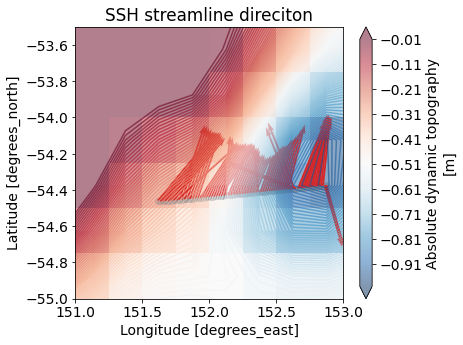

In [42]:
angle_rad = np.deg2rad(ssh_brngs)
speed = calc.speed(u, v)
y_vector = speed.mean(dim = 'depth_cell') * np.cos(angle_rad) 
x_vector = speed.mean(dim = 'depth_cell') * np.sin(angle_rad) 

times_no_nat = interp.interp_nats(adcp_sel.time, adcp_sel.time)
adt_interp_t = adt.interp(time = times_no_nat)

fig, ax = plt.subplots(figsize = (6,5))
adt_interp_t.isel(time = 50).plot(levels = ssh_contours, alpha = 0.5)
adt_interp_t.isel(time = 50).plot.contour(levels = ssh_contours, alpha = 0.6)
ax.scatter(lons, lats, c= 'slategrey', alpha = 0.3)
ax.quiver(lons, lats, x_vector, y_vector, color = 'tab:red', scale = 3)
plt.title('SSH streamline direciton')
plt.xlim(151,153)
plt.ylim(-55,-53.5)

In [43]:
u_rot = u_rot.assign_coords(depth_cell=depth.data)
v_rot = v_rot.assign_coords(depth_cell=depth.data)

Text(0, 0.5, 'depth (m)')

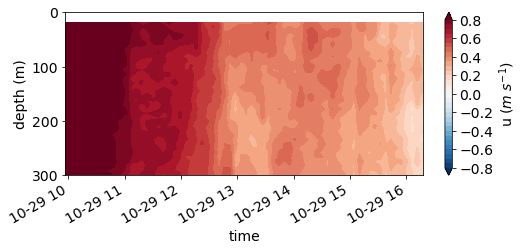

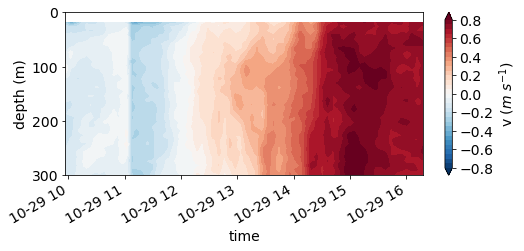

In [117]:
fig, ax = plt.subplots(figsize = (8,3))
u_rot.plot.contourf(x = 'time', cmap = 'RdBu_r', levels = np.arange(-0.8, 0.85, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'u ($m$ $s^{-1}$)'))
ax.set_ylim(0,300)
ax.invert_yaxis()
plt.xlabel('time')
plt.ylabel('depth (m)')

fig, ax = plt.subplots(figsize = (8,3))
v_rot.plot.contourf(x = 'time', cmap = 'RdBu_r', levels = np.arange(-0.8, 0.85, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'v ($m$ $s^{-1}$)'))
ax.set_ylim(0,300)
ax.invert_yaxis()
plt.xlabel('time')
plt.ylabel('depth (m)')

### Plot by distance

In [56]:
dist_diff = np.concatenate((np.array([0]), gsw.distance(lons.values, lats.values)))
dist_diff_km = dist_diff/1000
dist_from_start = np.nancumsum(dist_diff_km)

distance = xr.DataArray(dist_from_start, dims = 'distance')

In [57]:
along_front = xr.DataArray(u_rot.data, dims = ['distance', 'depth'], coords = dict(distance = ('distance', distance.data), 
                                                                                    depth = ('depth', u_rot.depth_cell.data)))
cross_front = xr.DataArray(v_rot.data, dims = ['distance', 'depth'], coords = dict(distance = ('distance', distance.data), 
                                                                                    depth = ('depth', v_rot.depth_cell.data)))

Text(0, 0.5, 'depth (m)')

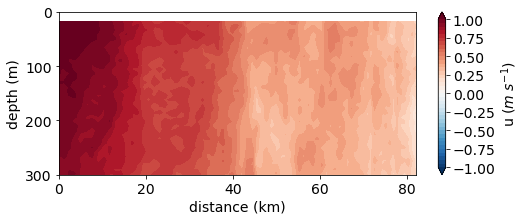

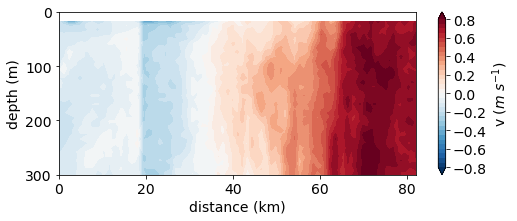

In [58]:
fig, ax = plt.subplots(figsize = (8,3))
along_front.plot.contourf(x = 'distance', cmap = 'RdBu_r', levels = np.arange(-1, 1.05, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'u ($m$ $s^{-1}$)'))
ax.set_ylim(0,300)
ax.invert_yaxis()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')

fig, ax = plt.subplots(figsize = (8,3))
cross_front.plot.contourf(x = 'distance', cmap = 'RdBu_r', levels = np.arange(-0.8, 0.85, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'v ($m$ $s^{-1}$)'))
ax.set_ylim(0,300)
ax.invert_yaxis()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')

### Rotate velocities relative to FSLE eigenvectors

In [59]:
# FLSE
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
ds = imports.importNetCDF(datadir, 'FSLE.nc').rename({'lat':'latitude', 'lon':'longitude'})
fsle_angle = ds.theta_max

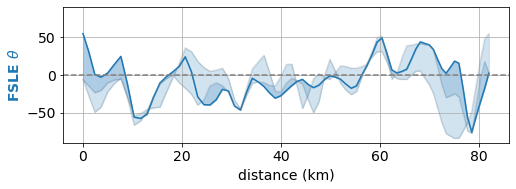

In [61]:
fig, ax = plt.subplots(figsize = (8,2.5))

interp_val, lower, upper = stats.temporalError(adcp_sel, fsle_angle, method = 'interp', rs = False)

plt.plot(distance, interp_val)
plt.plot(distance, lower, c = 'grey', alpha = 0.2)
plt.plot(distance, upper, c = 'grey', alpha = 0.2)

ax.fill_between(distance, lower, interp_val, alpha=0.2, color= 'tab:blue')
ax.fill_between(distance, interp_val, upper, alpha=0.2, color= 'tab:blue')

ax.grid()
ax.set_ylabel(r'FSLE $\theta$',  c= 'tab:blue', fontweight = 'bold')
ax.set_xlabel('distance (km)')
ax.set_ylim(-90,90)

plt.axhline(y = 0, linestyle = '--', c = 'grey')

In [62]:
values = abs(interp_val)

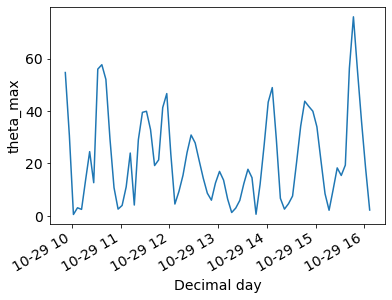

In [63]:
# transform into a bearing from N
values += 360
values = values % 360

values.plot()

In [64]:
u, v = adcp_sel.u, adcp_sel.v
fsle_brngs_2d = np.tile(values,(len(v[v.dims[1]]), 1)).transpose()

speed = calc.speed(u, v)
velocity_bearing = vel.uvBearing(u, v)

theta = fsle_brngs_2d - velocity_bearing
theta = (theta + 180) % 360 - 180

u_rot = speed * np.cos(theta*np.pi/180)
v_rot = speed * np.sin(theta*np.pi/180)

u_rot = u_rot.assign_coords(depth_cell=depth.data)
v_rot = v_rot.assign_coords(depth_cell=depth.data)

In [65]:
fsle_interp = stats.temporalError(adcp_sel, ds.fsle_max, method = 'interp')[0]

(-55.0, -53.5)

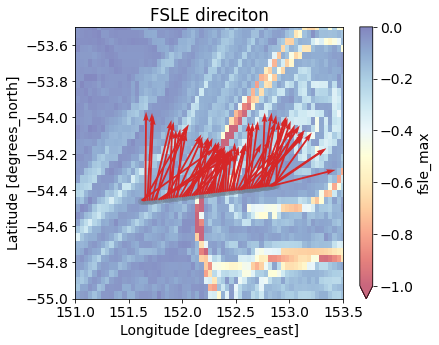

In [66]:
angle_rad = np.deg2rad(values)

y_vector = speed.mean(dim = 'depth_cell') * np.cos(angle_rad) 
x_vector = speed.mean(dim = 'depth_cell') * np.sin(angle_rad) 

times_no_nat = interp.interp_nats(adcp_sel.time, adcp_sel.time)
fsle_interp_t = ds.fsle_max.interp(time = times_no_nat)

fig, ax = plt.subplots(figsize = (6,5))

fsle_interp_t.mean(dim = 'time').plot(cmap = 'RdYlBu', alpha= 0.6, vmin = -1)

ax.scatter(lons, lats, c= 'slategrey', alpha = 0.3)
ax.quiver(lons, lats, x_vector, y_vector, color = 'tab:red', scale = 3)
plt.title('FSLE direciton')
plt.xlim(151,153.5)
plt.ylim(-55,-53.5)

In [67]:
along_front = xr.DataArray(u_rot.data, dims = ['distance', 'depth'], coords = dict(distance = ('distance', distance.data), 
                                                                                    depth = ('depth', u_rot.depth_cell.data)))
cross_front = xr.DataArray(v_rot.data, dims = ['distance', 'depth'], coords = dict(distance = ('distance', distance.data), 
                                                                                    depth = ('depth', v_rot.depth_cell.data)))

Text(0, 0.5, 'depth (m)')

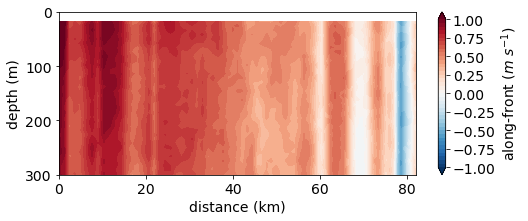

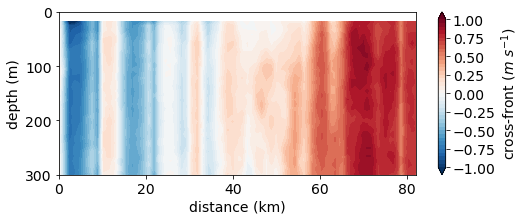

In [68]:
fig, ax = plt.subplots(figsize = (8,3))
along_front.plot.contourf(x = 'distance', cmap = 'RdBu_r', levels = np.arange(-1, 1.05, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'along-front ($m$ $s^{-1}$)'))
ax.set_ylim(0,300)
ax.invert_yaxis()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')

fig, ax = plt.subplots(figsize = (8,3))
cross_front.plot.contourf(x = 'distance', cmap = 'RdBu_r', levels = np.arange(-1,1.05, 0.05), 
                                extend = 'both', cbar_kwargs = dict(label = 'cross-front ($m$ $s^{-1}$)'))
ax.set_ylim(0,300)
ax.invert_yaxis()
plt.xlabel('distance (km)')
plt.ylabel('depth (m)')